# Notebook to explore the metric data columns

## Load libraries and predefine some functions

In [20]:
# !pip install ome_zarr 
!pip install ome_zarr | grep -v 'already satisfied' #avoid warnings

In [13]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nbvv
from upath import UPath as Path
from aicsimageio import AICSImage
from ome_zarr.reader import Reader
from ome_zarr.io import parse_url
import logging
logging.getLogger("bfio").setLevel(logging.ERROR)
logging.getLogger("aicsimageio").setLevel(logging.ERROR)


# Should these functions not be 

def read_ome_zarr(path, level=0, image_name="default"):
    path = str(path if image_name is None else Path(path) / image_name)
    reader = Reader(parse_url(path))

    node = next(iter(reader()))
    pps = node.metadata["coordinateTransformations"][0][0]["scale"][-3:]
   
    return AICSImage(
        node.data[level].compute(),
        channel_names=node.metadata["name"],
        physical_pixel_sizes=pps
    )

def rescale_image(img_data, channels):
    img_data = img_data.squeeze().astype(np.float32)
    
    for ix, channel in enumerate(channels):
        if "_seg" not in channel:
            img_data[ix] -= 1
            
            img_data[ix] = np.where(
                img_data[ix] >= 0,
                img_data[ix] / img_data.max(),
                -1
            )
    return img_data.astype(np.float16)

## Load the manifest and explore dimensions

In [24]:
cells_df = pd.read_parquet("s3://variance-dataset/processed/manifest.parquet")
print(f'Number of cells: {len(cells_df)}')
print(f'Number of columns: {len(cells_df.columns)}')

Number of cells: 215081
Number of columns: 1242


### Download a CSV file with n=10 cells to explore in Excel

In [25]:
cells_df.sample(n=10).to_csv('snippet.csv') #then right click on the file to download

## Make a couple of plots of metrics across 

### Make a bar plot of the number of cells per structure, stratified based on Microscope Pipeline ID

table = pd.pivot_table(cells_df, index="structure_name", columns="WorkflowId", aggfunc="size")
fig, axes = plt.subplots(figsize=(20, 7), dpi=100)
table.plot.barh(stacked=True, ax=axes)
axes.set_ylabel(None)
axes.set_title("Structures and Image Mode")
axes.grid(True, which="major", axis="x")
axes.set_axisbelow(True)
axes.invert_yaxis()
plt.show()

### Histogram for cell volume/height

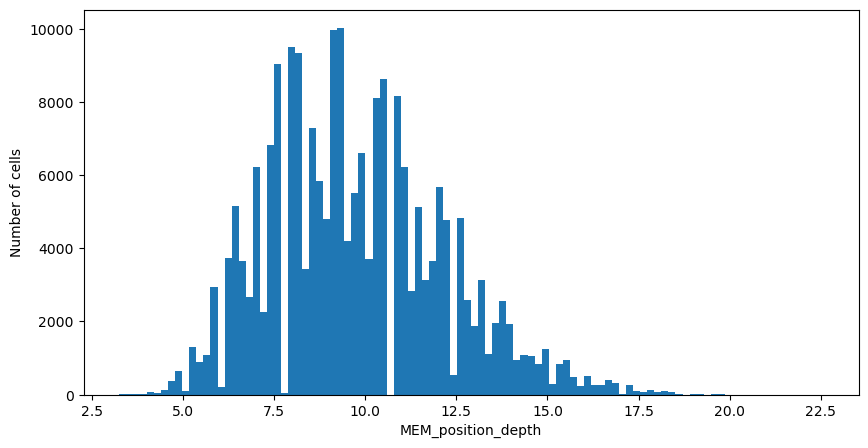

In [41]:
# select the metric (WE NEED MORE CLEAR LABELS THAN MEM_position_depth)
metric = "MEM_position_depth"
# convert pixels to micrometers (CONSIDER UPDATING DATASET TO USE MICROMETERS)
pix_size = 0.108
scl = pix_size**1
fig, axes = plt.subplots(figsize=(10, 5), dpi=100)
axes.hist(cells_df[metric] * scl, bins=100)
axes.set_xlabel(metric)
axes.set_ylabel("Number of cells")
plt.show()

### Make a violin plot of cell height across a given stratifier

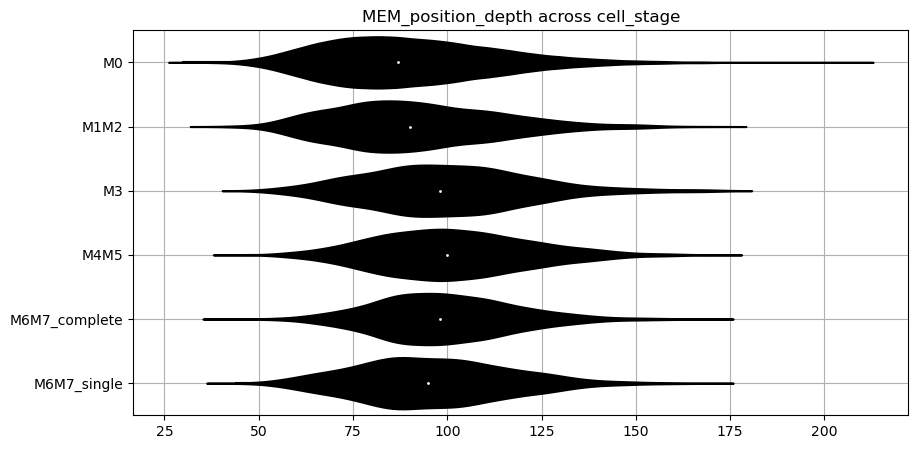

In [44]:
# select the metric (WE NEED MORE CLEAR LABELS THAN MEM_position_depth)
metric = "MEM_position_depth"
stratifier = "cell_stage"
order = np.sort(cells_df[stratifier].unique())
fig, axes = plt.subplots(figsize=(10, 5), dpi=100)
sns.violinplot(
    y=stratifier,
    x=metric,
    order = order,
    color="black",
    data=cells_df,
    scale="width",
    ax=axes
)

axes.set_title(f"{metric} across {stratifier}")
axes.grid(True, which="major", axis="both")
axes.set_axisbelow(True)
axes.set_ylabel(None)
axes.set_xlabel(None)

plt.show()

## Select a subset of cells (1,000 cells per mitotic stage) and plot some metrics for this subset